# Caso cuadrado

In [1]:
import numpy as np
import kdsource as kds
import mcpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

N = int(1E5) # Size of particle list

pt = "n"     # Particle type: neutron

# Energy
E0 = 0.5
sigma_u = 1
mu_u_1 = 5
mu_u_2 = 9
us_1 = np.random.normal(mu_u_1, sigma_u, (int(N/2),1))
us_2 = np.random.normal(mu_u_2, sigma_u, (int(N/2),1))
us = np.concatenate((us_1, us_2), axis=0)
Es = E0*np.ones(N)#E0 * np.exp(-us)
Es = Es.reshape(N,1)
# Position
poss_r = (np.random.uniform(0, 1, N))
poss_t = 2*np.pi * np.random.uniform(0, 1, N)-np.pi
poss_z = np.zeros(N)
poss = np.stack((np.sqrt(poss_r)*np.cos(poss_t), np.sqrt(poss_r)*np.sin(poss_t), poss_z),axis=-1)
poss = poss.reshape(N,3)
# Direction
mus = np.sqrt(np.random.uniform(0,1,N))
phis = np.random.uniform(-np.pi,np.pi,N)
dxs = np.sqrt(1-mus**2) * np.cos(phis)
dys = np.sqrt(1-mus**2) * np.sin(phis)
dzs = mus
dirs = np.stack((dxs,dys,dzs), axis=1)
# Time
t = np.zeros(N)
t = t.reshape(N,1)
# Stack energies, positions and directions
parts = np.concatenate((Es,poss,dirs, t), axis=1)
np.random.shuffle(parts)
# Weights
sigma_w = 0.1
ws = np.random.normal(1, sigma_w, N)

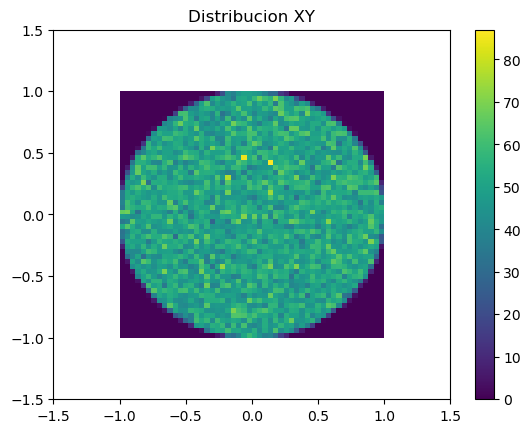

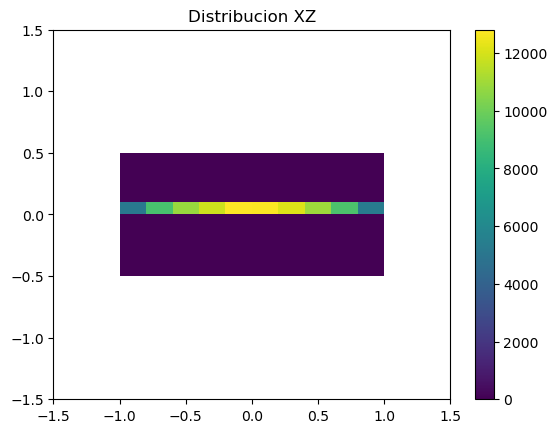

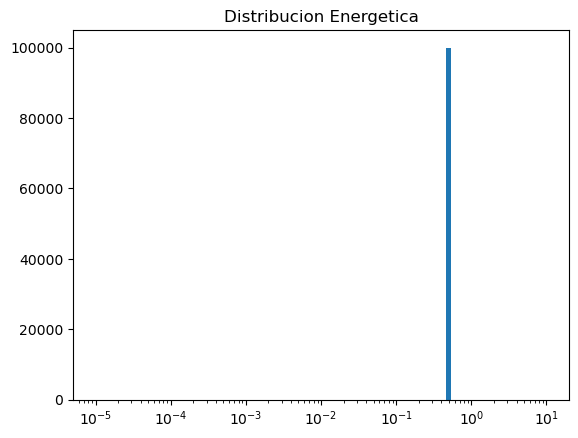

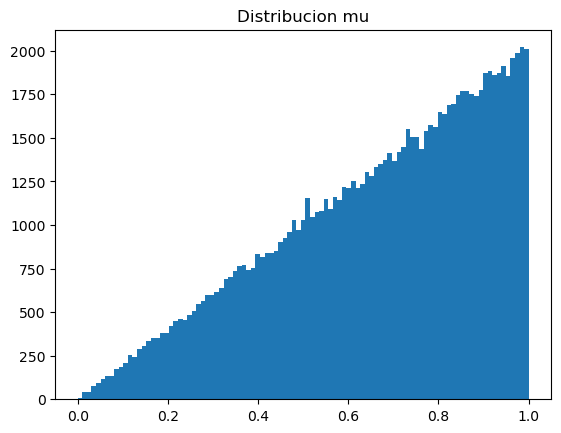

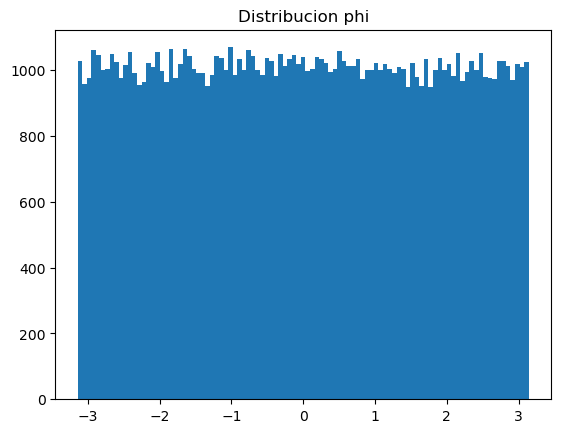

In [2]:
plt.hist2d(poss[:,0], poss[:,1], bins=(50,50))
plt.xlim(-1.5,1.5)
plt.ylim(-1.5,1.5)
plt.title("Distribucion XY")
plt.colorbar()
plt.show()


plt.hist2d(poss[:,0], poss[:,2])
plt.xlim(-1.5,1.5)
plt.ylim(-1.5,1.5)
plt.title("Distribucion XZ")
plt.colorbar()
plt.show()


bins = np.logspace(-5,1,100)
plt.hist(Es, bins=bins)
plt.title("Distribucion save")
plt.show()

bins = np.linspace(0,1,100)
plt.hist(mus, bins=bins)
plt.title("Distribucion mu")
plt.show()

bins = np.linspace(-np.pi,np.pi,100)
plt.hist(phis, bins=bins)
plt.title("Distribucion phi")
plt.show()

In [3]:
ssvfile = "samples.ssv"
kds.plist.savessv(pt, parts, ws, ssvfile)        # Save as SSV file
samples = kds.convert2mcpl(ssvfile, "ssv") # Convert to MCPL

Writing particles into SSV file...
Done. All particles written into samples.ssv
Using existing file samples.mcpl.gz


# Create and optimize KDSource

## Create KDSource

In [4]:
# PList: wrapper for MCPL file
plist = kds.PList(samples)
# Geometry: define metrics for variables
geom = kds.Geometry([kds.geom.Energy(),
                    kds.geom.SurfR(rho_min=0, rho_max=1.0, psi_min=-np.pi, psi_max=np.pi),
                    kds.geom.Isotrop()])
# Create KDSource



s = kds.KDSource(plist, geom)


Using existing file samples.mcpl.gz
sum_weights = 100009.49885874987
p2 = 101016.23757401746
N = 100000
N_eff = 99012.79341006554


## Optimize bandwidth

In [5]:
# Give a little more importance to energy
var_importance = [3,1,1,1,1,1]

parts,ws = s.plist.get(N=-1)
scaling = s.geom.std(parts=parts)
scaling /= var_importance

In [6]:
# Number of particles to use for optimization.
# A large number (1E5 or more) gives better bandwidths, but takes longer to
# compute.
N = 1E5


Choose one of the available bandwidth optimization methods. Recommended method is Method 3 (adaptive MLCV)

In [7]:
# Method 1: Silverman's Rule: Simple and fast method.
# BW is chosen based on only on the number of particles, and dimension of
# geometry.

s.bw_method = "silv"
s.fit(N, scaling=scaling)

Using 100000 particles for fit.
Calculating bw ... 
Done
Optimal bw (silv) = [[ 0.29534381  0.06957768 30.73984236  0.13936851  0.13936851  0.13936851]]


Using 10000 particles for fit.
Calculating bw ... 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:   25.8s remaining:   25.8s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:   26.7s remaining:   11.4s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   34.0s finished


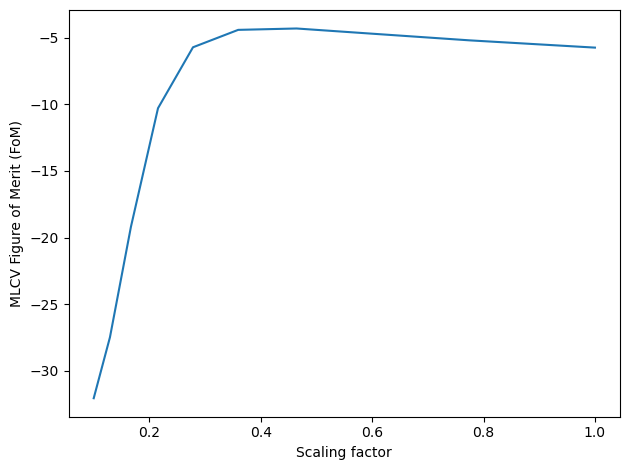

Done
Optimal bw (mlcv) = [[ 0.17258254  0.04065734 17.96265917  0.08143923  0.08143923  0.08143923]]
Using 100000 particles for fit.


In [8]:
# Method 2: Non-adaptive Maximum Likelihood Cross-Validation:
# Creates a grid of non-adaptive bandwidths and evaluates the
# cross-validation scores on each one, which is an indicator of the
# quality of the estimation. Selects the bandwidth that optimizes
# CV score.

s.bw_method = "mlcv"
seed = None # Default: Use the Silverman's Rule as seed
grid = np.logspace(-1,0,10)

N_cv = int(1E4) # Use a smaller N to reduce computation times
s.fit(N_cv, scaling=scaling, seed=seed, grid=grid)

bw = s.kde.bw
dim = s.geom.dim
bw *= kds.bw_silv(dim,N)/kds.bw_silv(dim,N_cv) # Apply Silverman factor
s = kds.KDSource(plist, geom, bw=bw) # Create new KDSource with adapted BW
s.fit(N=N, scaling=scaling)


Using 100000 particles for fit.
Calculating bw ... 
Using k = 10 neighbors per batch (batch_size = 10000)
Correction factor: f_k = k_float / k = 1.0
Effective total neighbors: K_eff = 100.0
batch = 1 / 10
batch = 2 / 10
batch = 3 / 10
batch = 4 / 10
batch = 5 / 10
batch = 6 / 10
batch = 7 / 10
batch = 8 / 10
batch = 9 / 10
batch = 10 / 10
Done
Optimal bw (knn) = [[ 0.6485088   0.15277698 67.49780326  0.30602201  0.30602201  0.30602201]
 [ 0.40300296  0.09494023 41.94517436  0.19017133  0.19017133  0.19017133]
 [ 0.43175804  0.10171441 44.93804746  0.20374043  0.20374043  0.20374043]
 ...
 [ 0.4750564   0.11191472 49.444608    0.22417231  0.22417231  0.22417231]
 [ 0.5326534   0.12548354 55.43939391  0.25135151  0.25135151  0.25135151]
 [ 0.53519471  0.12608222 55.70389649  0.25255072  0.25255072  0.25255072]]
Using 10000 particles for fit.
Calculating bw ... 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:   14.0s remaining:   14.0s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:   22.0s remaining:    9.4s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   33.8s finished


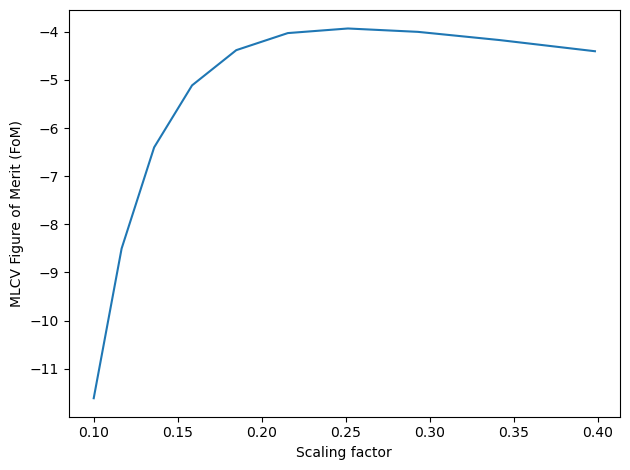

Done
Optimal bw (mlcv) = [[ 0.16289804  0.03837584 16.95468162  0.07686925  0.07686925  0.07686925]
 [ 0.10122977  0.02384791 10.53615143  0.04776888  0.04776888  0.04776888]
 [ 0.10845272  0.0255495  11.28792717  0.05117728  0.05117728  0.05117728]
 ...
 [ 0.12189412  0.02871606 12.68692893  0.05752009  0.05752009  0.05752009]
 [ 0.11378642  0.02680603 11.84306776  0.05369418  0.05369418  0.05369418]
 [ 0.12214149  0.02877433 12.71267658  0.05763682  0.05763682  0.05763682]]
Using 100000 particles for fit.


In [9]:
# Method 3: Adaptive Maximum Likelihood Cross-Validation:
# Creates a grid of adaptive bandwidths and evaluates the
# cross-validation scores on each one, which is an indicator of the
# quality of the estimation. Selects the bandwidth that optimizes
# CV score.
# kNN is used to generate the seed adaptive bandwidth.

# kNN bandwidth
s.bw_method = "knn"
batch_size = 10000 # Batch size for KNN search
k = 10             # Numer of neighbors per batch
s.fit(N, scaling=scaling, batch_size=batch_size, k=k)
bw_knn = s.kde.bw

# MLCV optimization of previously calculated kNN bandwidth
s.bw_method = "mlcv"
N_cv = int(1E4)   # Use a smaller N to reduce computation times
seed = bw_knn[:N_cv] # Use kNN BW as seed (first N elements)
grid = np.logspace(-1,-0.4,10)
s.fit(N_cv, scaling=scaling, seed=seed, grid=grid)
bw_cv = s.kde.bw

# Extend MLCV optimization to full KNN BW
bw_knn_cv = bw_knn * bw_cv[0]/bw_knn[0] # Apply MLCV factor
dim = s.geom.dim
bw_knn_cv *= kds.bw_silv(dim,len(bw_knn))/kds.bw_silv(dim,len(bw_cv)) # Apply Silverman factor
s = kds.KDSource(plist, geom, bw=bw_knn_cv) # Create new KDSource with full BW
s.fit(N=N, scaling=scaling)

# Resample

In [10]:
xmlfile = "source.xml"
s.save(xmlfile) # Save KDSource to XML file

N_resampled = 1E6 # Number of particles to generate with virtual KDE source
!kdtool resample "$xmlfile" -o "resampled" -n $N_resampled
resampled = "resampled.mcpl.gz"

Bandwidth file: samples_bws
Successfully saved parameters file source.xml
Reading xmlfile source.xml...
Done.
Resampling...
MCPL: Attempting to compress file resampled.mcpl with gzip
MCPL: Succesfully compressed file into resampled.mcpl.gz
Successfully sampled 1000000 particles.


A new MCPL file has been created, named "resampled.mcpl.gz", with particles generated from the KDE-based distribution.

In [11]:
import surface_source as ss

In [12]:
olds = ss.SurfaceSource("samples.mcpl.gz")
df_old = olds.get_pandas_dataframe()
df_old

,id,type,E,x,y,z,u,v,w,t,...,px,py,pz,userflags,R,theta,mu,psi,phi,log(E0/E)
0,0,2112,0.5,-0.412198,0.161129,0.0,-0.685426,-0.563924,0.460631,0.0,...,0.0,0.0,0.0,0,0.442572,2.768953,0.460631,1.092090,-2.453142,1.60206
1,1,2112,0.5,0.059301,-0.956228,0.0,0.039947,-0.267762,0.962657,0.0,...,0.0,0.0,0.0,0,0.958065,-1.508860,0.962657,0.274146,-1.422702,1.60206
2,2,2112,0.5,0.279283,0.788188,0.0,-0.569974,-0.543200,0.616493,0.0,...,0.0,0.0,0.0,0,0.836205,1.230264,0.616493,0.906516,-2.380242,1.60206
3,3,2112,0.5,0.728264,0.021792,0.0,0.121047,-0.176733,0.976787,0.0,...,0.0,0.0,0.0,0,0.728590,0.029914,0.976787,0.215885,-0.970267,1.60206
4,4,2112,0.5,-0.746308,0.610395,0.0,-0.038563,-0.552068,0.832907,0.0,...,0.0,0.0,0.0,0,0.964136,2.456040,0.832907,0.586457,-1.640536,1.60206
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,99995,2112,0.5,0.562849,-0.816753,0.0,0.005973,0.730503,0.682884,0.0,...,0.0,0.0,0.0,0,0.991909,-0.967403,0.682884,0.819093,1.562620,1.60206
99996,99996,2112,0.5,0.059097,0.400686,0.0,-0.830417,-0.532840,0.162756,0.0,...,0.0,0.0,0.0,0,0.405021,1.424362,0.162756,1.407313,-2.571107,1.60206
99997,99997,2112,0.5,-0.521015,-0.701530,0.0,-0.729195,-0.583113,0.358124,0.0,...,0.0,0.0,0.0,0,0.873842,-2.209599,0.358124,1.204538,-2.467055,1.60206
99998,99998,2112,0.5,0.797705,-0.380284,0.0,0.457004,-0.764807,0.454112,0.0,...,0.0,0.0,0.0,0,0.883713,-0.444853,0.454112,1.099421,-1.032186,1.60206


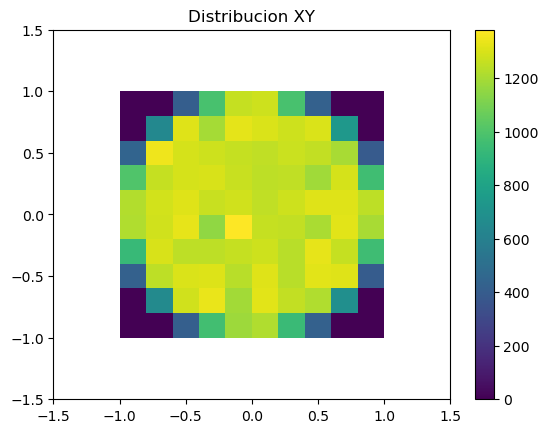

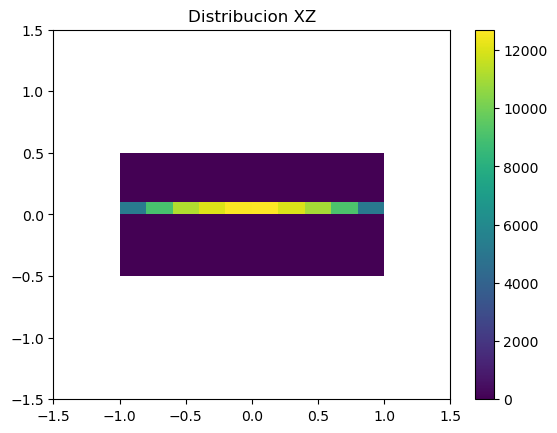

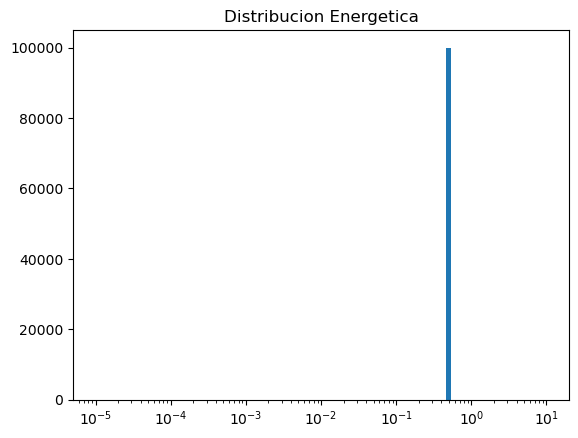

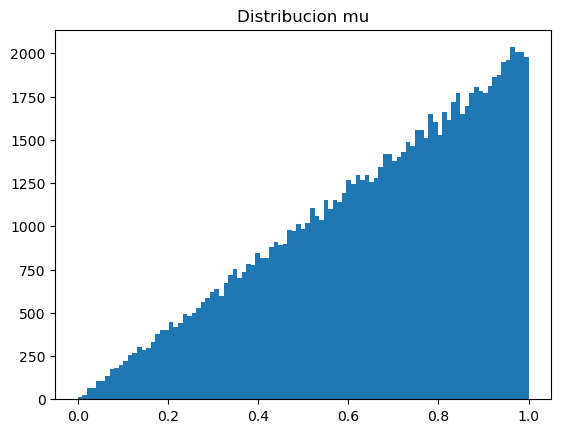

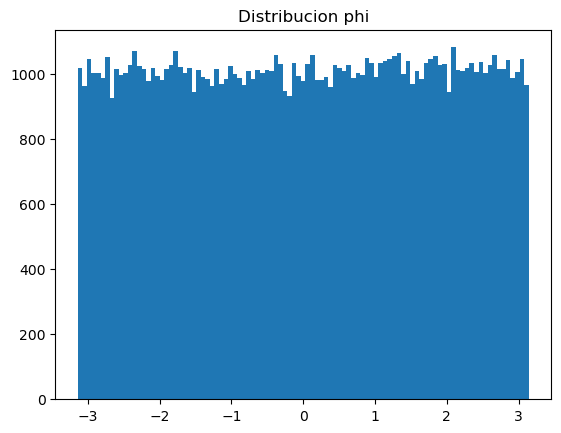

In [13]:
plt.hist2d(df_old["x"], df_old["y"])
plt.xlim(-1.5,1.5)
plt.ylim(-1.5,1.5)
plt.title("Distribucion XY")
plt.colorbar()
plt.show()


plt.hist2d(df_old["x"], df_old["z"])
plt.xlim(-1.5,1.5)
plt.ylim(-1.5,1.5)
plt.title("Distribucion XZ")
plt.colorbar()
plt.show()


bins = np.logspace(-5,1,100)
plt.hist(df_old["E"], bins=bins)
plt.title("Distribucion Energetica")
plt.xscale("log")
plt.show()

bins = np.linspace(0,1,100)
plt.hist(df_old["mu"], bins=bins)
plt.title("Distribucion mu")
plt.show()

bins = np.linspace(-np.pi,np.pi,100)
plt.hist(df_old["phi"], bins=bins)
plt.title("Distribucion phi")
plt.show()

In [14]:
news = ss.SurfaceSource("resampled.mcpl.gz")
news

In [15]:
df_new = news.get_pandas_dataframe()
df_new

,id,type,E,x,y,z,u,v,w,t,...,px,py,pz,userflags,R,theta,mu,psi,phi,log(E0/E)
0,0,2112,0.452253,0.210689,0.230548,0.0,0.406653,-0.443312,0.798817,0.0,...,0.0,0.0,0.0,0,0.312318,0.830375,0.798817,0.645470,-0.828501,1.645649
1,1,2112,0.416354,-0.886062,-0.375668,0.0,0.407480,0.603228,0.685620,0.0,...,0.0,0.0,0.0,0,0.962410,-2.740591,0.685620,0.815341,0.976704,1.681567
2,2,2112,0.314543,-0.240839,0.086508,0.0,-0.185682,-0.541392,0.820010,0.0,...,0.0,0.0,0.0,0,0.255904,2.796751,0.820010,0.609367,-1.901197,1.803350
3,3,2112,0.715962,0.539863,0.770730,0.0,-0.608889,-0.725687,0.320364,0.0,...,0.0,0.0,0.0,0,0.940998,0.959764,0.320364,1.244683,-2.268900,1.446140
4,4,2112,0.663512,-0.567333,-0.269592,0.0,0.265764,-0.958103,0.106808,0.0,...,0.0,0.0,0.0,0,0.628129,-2.697988,0.106808,1.463784,-1.300214,1.479181
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,999995,2112,0.245060,-0.349857,0.226037,0.0,0.207448,-0.081413,0.974852,0.0,...,0.0,0.0,0.0,0,0.416524,2.567975,0.974852,0.224738,-0.373980,1.911757
999996,999996,2112,0.331880,-0.266714,-0.366762,0.0,0.088940,-0.368364,0.925418,0.0,...,0.0,0.0,0.0,0,0.453487,-2.199554,0.925418,0.388660,-1.333886,1.780049
999997,999997,2112,0.553477,-0.601883,0.241862,0.0,-0.794057,0.220173,0.566566,0.0,...,0.0,0.0,0.0,0,0.648661,2.759499,0.566566,0.968464,2.871111,1.557930
999998,999998,2112,0.508807,0.479850,-0.307865,0.0,0.487167,0.755770,0.437585,0.0,...,0.0,0.0,0.0,0,0.570120,-0.570437,0.437585,1.117885,0.998229,1.594477


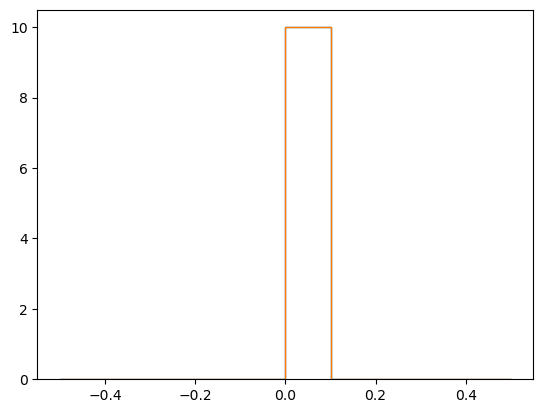

In [16]:
plt.hist(df_new["z"], density= True ,histtype='step' )
plt.hist(df_old["z"], density= True, histtype='step')

plt.show()

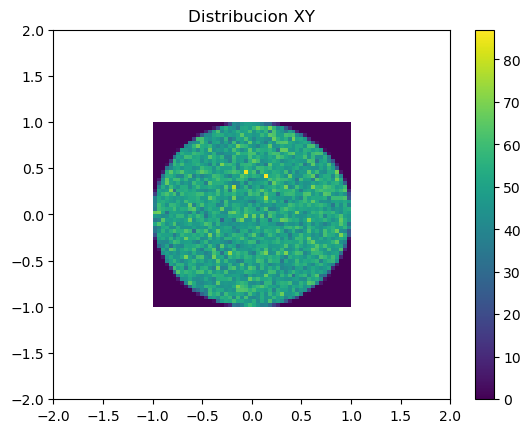

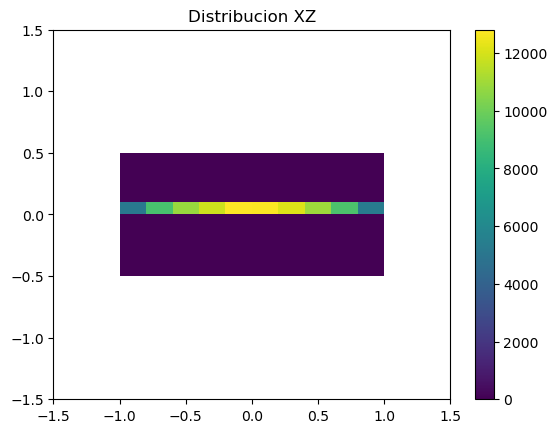

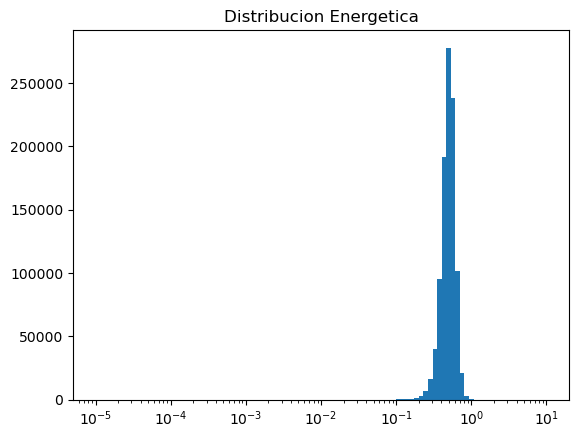

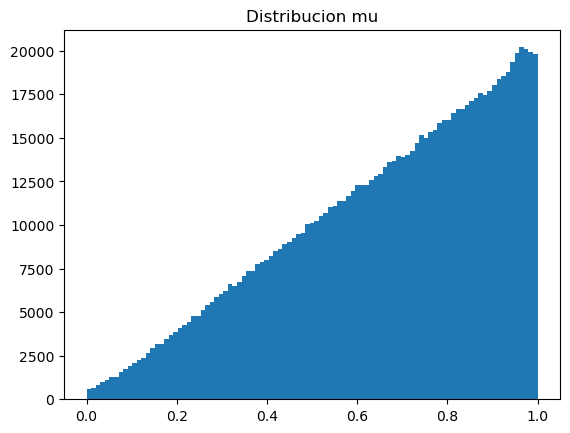

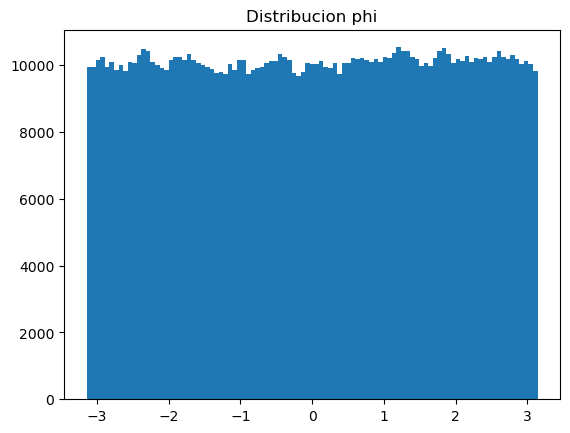

In [17]:
plt.hist2d(poss[:,0], poss[:,1], bins=(50,50))
plt.xlim(-2,2)
plt.ylim(-2,2)
plt.title("Distribucion XY")
plt.colorbar()
plt.show()


plt.hist2d(poss[:,0], poss[:,2])
plt.xlim(-1.5,1.5)
plt.ylim(-1.5,1.5)
plt.title("Distribucion XZ")
plt.colorbar()
plt.show()


bins = np.logspace(-5,1,100)
plt.hist(df_new["E"], bins=bins)
plt.title("Distribucion Energetica")
plt.xscale("log")
plt.show()

bins = np.linspace(0,1,100)
plt.hist(df_new["mu"], bins=bins)
plt.title("Distribucion mu")
plt.show()

bins = np.linspace(-np.pi,np.pi,100)
plt.hist(df_new["phi"], bins=bins)
plt.title("Distribucion phi")
plt.show()